In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

!pip install prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """
        Calculates MAPE given y_true and y_pred
        Credit to Rob Mulla
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
path= '/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv'
df= pd.read_csv(path)

In [3]:
def clean_df(df):
    return (df
        .assign(
            dt= lambda df_: pd.to_datetime(df_['dt']) # cast to to datetime
        )
        .loc[(df['Country'] == 'Indonesia') & (df['dt'] >= '1900-01-01')] # fiter to indonesia after year 1900
        .drop(columns= ['AverageTemperatureUncertainty', 'Country']) # drop unused col
        .set_index('dt') # set dt as index
        .resample('MS') 
        .interpolate(motehod= 'time') # interpolate missing temperature
    )

In [4]:
df_clean= clean_df(df)

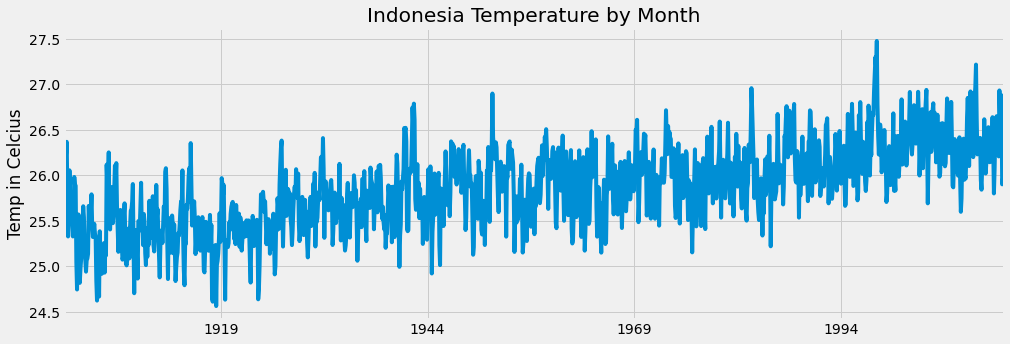

In [5]:
(df_clean
    .plot(
        figsize= (15, 5),
        style= '-',
        title= 'Indonesia Temperature by Month',
        legend= False,
        xlabel= '',
        ylabel= 'Temp in Celcius'
    )
)

plt.show()

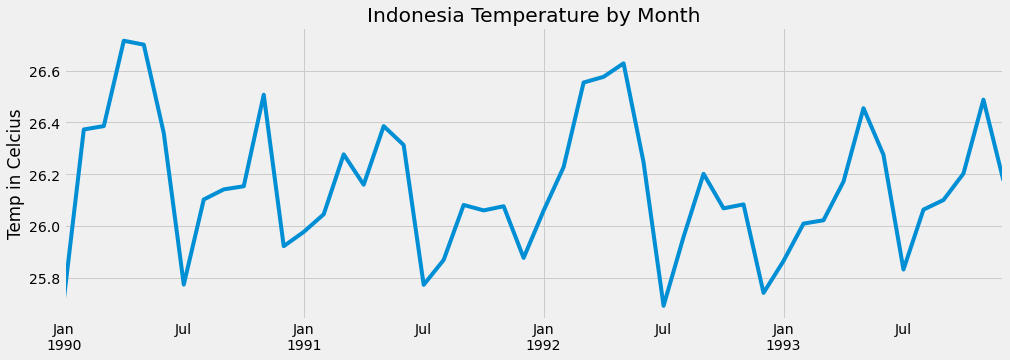

In [6]:
(df_clean
    .loc[
        (df_clean.index.year.isin(list(range(1990, 1994))))
    ]
    .plot(
        figsize= (15, 5),
        style= '-',
        title= 'Indonesia Temperature by Month',
        legend= False,
        xlabel= '',
        ylabel= 'Temp in Celcius'
    )
)

plt.show()

In [7]:
num_train= round(len(df_clean) * 0.75)

train= df_clean.iloc[:num_train]
test= df_clean.iloc[num_train:]

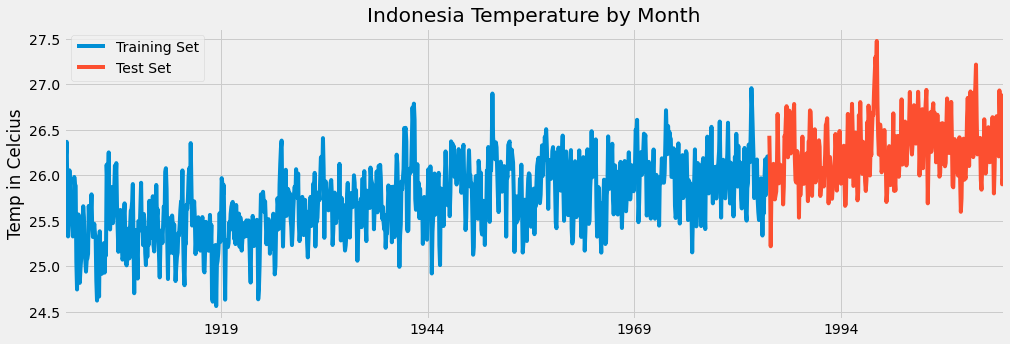

In [8]:
fig, ax= plt.subplots(figsize= (15, 5))
train.plot(
    ax= ax, 
    label= 'Training Set'
)
test.plot(
    ax= ax, 
    label= 'Test Set'
)

ax.set_title('Indonesia Temperature by Month')
ax.set_xlabel('')
ax.set_ylabel('Temp in Celcius')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
def create_prophet_set(df): 
    return (df
        .reset_index()
        .rename(columns= {
            'dt': 'ds',
            'AverageTemperature': 'y'
        })
    )

train_prophet= create_prophet_set(train)
test_prophet= create_prophet_set(test)

In [10]:
model_prophet= Prophet()
model_prophet.fit(train_prophet)

09:42:48 - cmdstanpy - INFO - Chain [1] start processing
09:42:48 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
preds= model_prophet.predict(test_prophet)

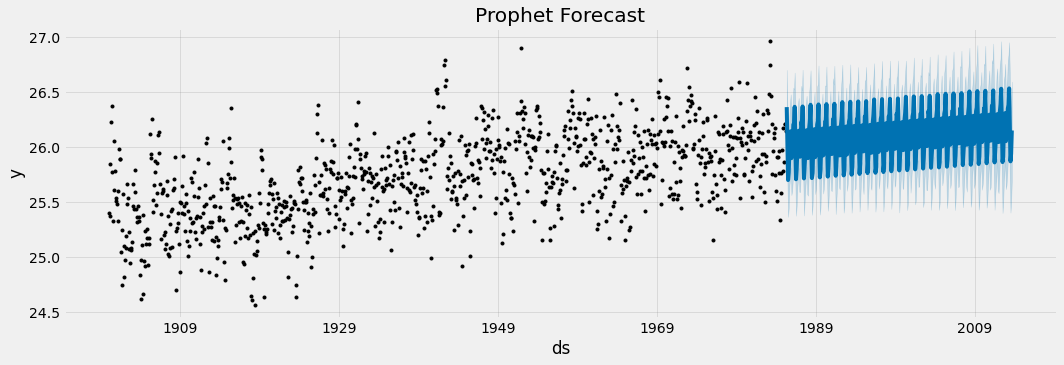

In [12]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(
    preds,
    ax= ax
)
ax.set_title('Prophet Forecast')
plt.show()

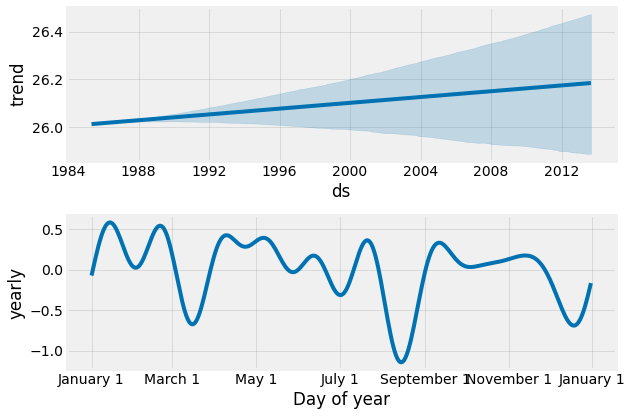

In [13]:
fig= model_prophet.plot_components(preds)
plt.show()

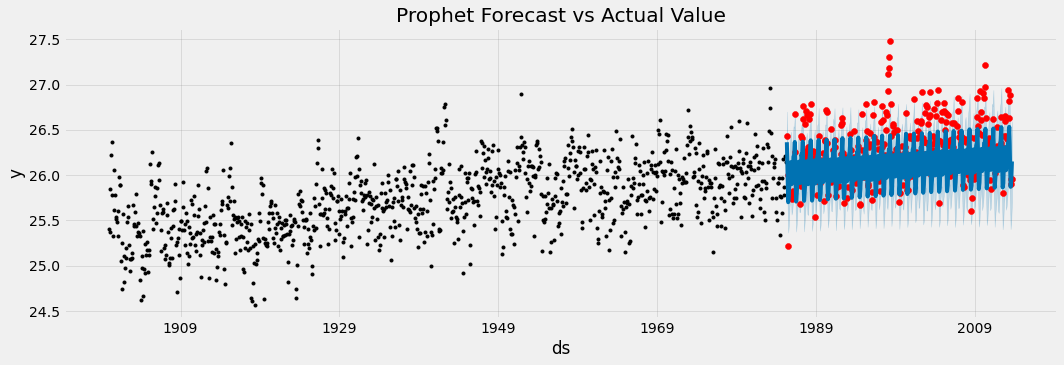

In [14]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(preds, ax= ax)
ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red')
ax.set_title('Prophet Forecast vs Actual Value')
plt.show()

In [15]:
test_prophet['ds'].min()

Timestamp('1985-05-01 00:00:00')

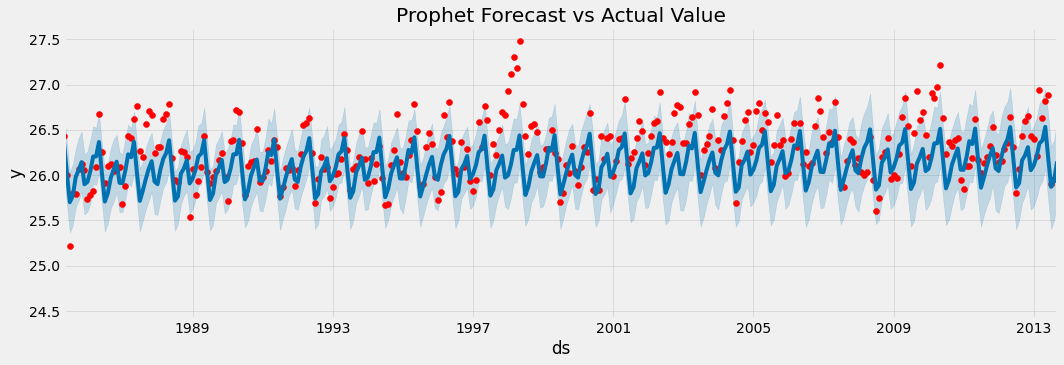

In [16]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(preds, ax= ax)
ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red')
ax.set_title('Prophet Forecast vs Actual Value')
ax.set_xbound(
    lower= test_prophet['ds'].min(),
    upper= test_prophet['ds'].max()
)
plt.show()

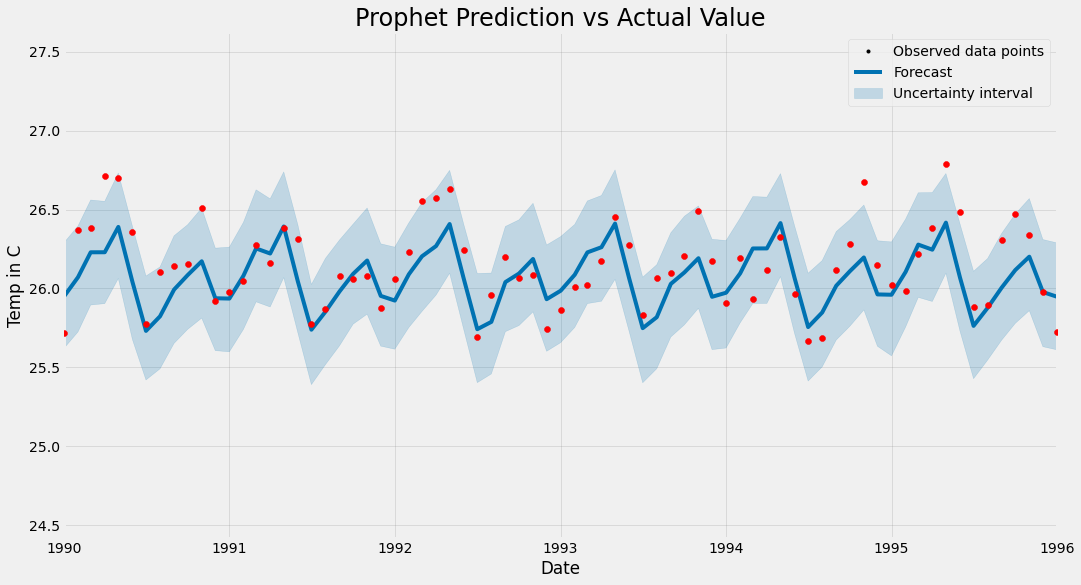

In [17]:
fig, ax= plt.subplots(figsize= (15, 8))

ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red', zorder= 5)
ax.legend()
model_prophet.plot(preds, ax= ax)

ax.legend()
ax.set_title('Prophet Prediction vs Actual Value', fontsize= 24)
ax.set_xbound(
    lower= pd.to_datetime('1990-01-01'),
    upper= pd.to_datetime('1996-01-01')
)
ax.set_ylabel('Temp in C')
ax.set_xlabel('Date')

plt.savefig('plot.png', dpi= 300, bbox_inches = "tight")
plt.show()

In [18]:
rmse= np.sqrt(mean_squared_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
))
mae= mean_absolute_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
)
mape= mean_absolute_percentage_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
)

print(f'Root mean squared error: {round(rmse, 3)} degree Celcius.')
print(f'Mean absolute error: {round(mae, 3)} degree Celcius.')
print(f'Mean absolute percentage error: {round(mape, 3)}%')

Root mean squared error: 0.309 degree Celcius.
Mean absolute error: 0.242 degree Celcius.
Mean absolute percentage error: 0.914%
